# About Q-Learning algorithm
> "Q-learning is a model-free reinforcement learning algorithm. The goal of Q-learning is to learn a policy, which tells an agent what action to take under what circumstances. It does not require a model (hence the connotation "model-free") of the environment, and it can handle problems with stochastic transitions and rewards, without requiring adaptations."
[*wiki*](https://en.wikipedia.org/wiki/Q-learning)

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import matplotlib as mpl
import joblib
import os
import keras

import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [2]:
import gym

#### 다른 gym 실험

gymnasium.make("Blackjack-v1")

In [17]:
import gym
keras.backend.clear_session()
env = gym.make("Blackjack-v1", natural = False, sab = False)
env.seed(77)
# input_shape = [4]
# n_outputs = 2

[77]

In [18]:
# 환경 초기화
obs = env.reset()
obs

(17, 1, False)

In [19]:
env.render()
img = env.render(mode="rgb_array")
img.shape

(500, 600, 3)

In [20]:
# 이미지 변환 함수 정의
def plot_environment(env, figsize = (5,4)):
  plt.figure(figsize=figsize)
  img = env.render(mode="rgb_array")
  plt.imshow(img)
  plt.axis("off")
  return img

<function matplotlib.pyplot.show(close=None, block=None)>

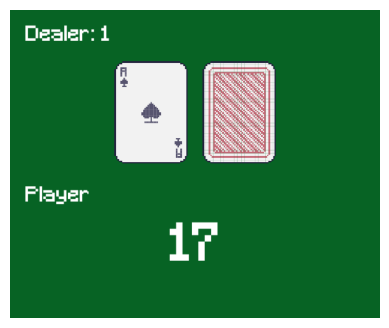

In [21]:
# 블랙잭 이미지 표시
plot_environment(env)
plt.show

In [22]:
# 행동할 수 있는 종류
env.action_space

Discrete(2)

관측(내 손, 딜러 손, 에이스 여부), 리워드, 결과값, 정보 : ((7, 10, False), -1.0, True, {'TimeLimit.truncated': False})


<function matplotlib.pyplot.show(close=None, block=None)>

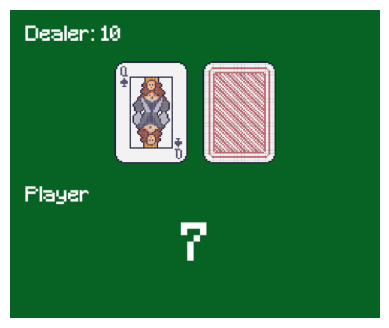

In [67]:
# 숫자 증가
action = 0
obs, reward, done, info = env.step(action)
print(f"관측(내 손, 딜러 손, 에이스 여부), 리워드, 결과값, 정보 : {env.step(action)}")
# obs = 플레이어의 현재 합계/ 딜러가 보여준 카드의 가치(값)/ 사용가능한 에이스로 구성
# 이미지 표시
plot_environment(env)
plt.show

In [31]:
# 리워드 표시
reward

-1.0

In [32]:
done, info

(True, {'TimeLimit.truncated': False})

In [68]:
# 간단한 policy
def basic_policy(obs):
  player_current_sum = obs[0]
  value_of_the_dealers_one = obs[1]
  usable_ace = obs[2]
  if usable_ace == True:
    usable_ace = 11
  else:
    usable_ace = 0
  player_final_score = abs(21 - (player_current_sum + usable_ace))
  dealer_final_score = abs(21 - value_of_the_dealers_one)
  # 플레이어 예측 vs 딜러 예측(실제 카드)
  # 21에서 카드 숫자를 제외한 점수의 절대값이 더 낮은 쪽이 승리로 가는 알고리즘
  # '21'보다 실제 카드 숫자가 더 클수도 있다는 점 고려
  # 에이스 카드 사용
  return 0 if player_final_score > dealer_final_score else 1
totals = []

In [69]:
basic_policy
# 리워드는 둘중 하나. 승(1)과 패(0)

<function __main__.basic_policy(obs)>

In [70]:
# 에피소드 500회
for episode in range(500):
  episode_rewards = 0
  obs = env.reset()
  for step in range(200):
    action = basic_policy(obs)
    obs, reward, done, info = env.step(action)
    episode_rewards += reward
    if done:
      break
  totals.append(episode_rewards)

In [58]:
totals[:20]

[0.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0]

In [95]:
# 프레임에 삽입
# 10 에피소드부터 시작
frames=[]
obs = env.reset()
for episode in range(10):
  episode_rewards = 0
  obs = env.reset()
  for step in range(4):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)
    obs, reward, done, info = env.step(action)
    episode_rewards += reward
    if done:
      break
  totals.append(episode_rewards)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [96]:
# 출력
def update_scene(num, frames, patch):
  patch.set_data(frames[num])
  return patch,

def plot_animation(frames, repeat = False, interval=10):
  fig = plt.figure()
  patch = plt.imshow(frames[0])
  plt.axis('off')
  anim = animation.FuncAnimation(
      fig, update_scene, fargs=(frames, patch),
      frames = len(frames), repeat=repeat, interval = interval
  )
  plt.close()
  return anim
plot_animation(frames)

In [88]:
frames[1][1]

array([[ 7, 99, 36],
       [ 7, 99, 36],
       [ 7, 99, 36],
       ...,
       [ 7, 99, 36],
       [ 7, 99, 36],
       [ 7, 99, 36]], dtype=uint8)

In [85]:
frames[0][2]

array([[ 7, 99, 36],
       [ 7, 99, 36],
       [ 7, 99, 36],
       ...,
       [ 7, 99, 36],
       [ 7, 99, 36],
       [ 7, 99, 36]], dtype=uint8)